In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
df_latest = pd.read_excel("/content/drive/MyDrive/DSCI521 Group Work/DSCI521 Project/enrollment_expenditure_covar_df.xlsx")

# define features and target
features = ["totalPop", "white", "black", "AIAN", "asian", "NHPI", "otherRace", "twoplusRace", "notHispanicLatino", "hispanicLatino", "medianIncome", "inLaborForce", "employed", "unemployed"]
target = "Average Total Medicaid and CHIP Enrollment"

df_lstm = df_latest[features + [target, "YEAR"]].copy()
df_lstm.fillna(df_lstm.median(), inplace=True)

# extract years
years = df_lstm["YEAR"].values

# separate features and target, apply scaling
X = df_lstm[features].values
y = df_lstm[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# split data
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(
    X_lstm, y_scaled, years, test_size=0.2, random_state=42, shuffle=True
)

# convert to pytorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# define lstm model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, input_size)  # predict features too

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return out

# initialize model
input_size = len(features)
hidden_size = 50
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, X_train_torch[:, -1, :])  # predict features too
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# make predictions
y_pred_torch = model(X_test_torch).detach().numpy()
y_pred_inv = scaler_y.inverse_transform(y_pred_torch[:, 0].reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)

# predict future values (use predicted features as input)
future_years = np.arange(years[-1] + 1, 2027)
X_future = X_scaled[-1].reshape(1, 1, -1)  # start with last known data
y_future_pred_inv = []

for _ in future_years:
    X_future_torch = torch.tensor(X_future, dtype=torch.float32)
    X_future_pred = model(X_future_torch).detach().numpy()
    X_future_pred_inv = scaler_X.inverse_transform(X_future_pred)  # convert predicted features

    y_future_pred_inv.append(X_future_pred_inv[0, 0])  # store predicted target

    # use predicted features as next input
    X_future = X_future_pred.reshape(1, 1, -1)

# function to compute yearly average
def compute_yearly_avg(years, values):
    df_temp = pd.DataFrame({"year": years, "value": values.flatten()})
    return df_temp.groupby("year").mean()

actual_avg = compute_yearly_avg(years_test, y_test_inv)
predicted_avg = compute_yearly_avg(years_test, y_pred_inv)
future_avg = pd.DataFrame({"year": future_years, "value": y_future_pred_inv}).groupby("year").mean()

# merge predicted and future data
predicted_avg = pd.concat([predicted_avg, future_avg]).sort_index()


Epoch [10/50], Loss: 0.0213
Epoch [20/50], Loss: 0.0125
Epoch [30/50], Loss: 0.0105
Epoch [40/50], Loss: 0.0074
Epoch [50/50], Loss: 0.0067


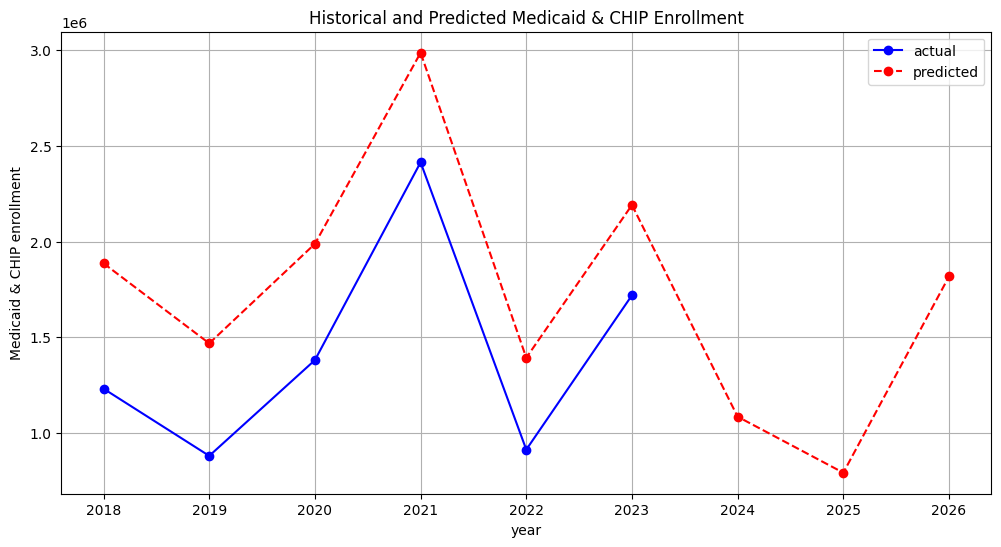

In [ ]:
# plot results
plt.figure(figsize=(12, 6))
plt.plot(actual_avg.index, actual_avg["value"], marker="o", label="actual", color="blue")
plt.plot(predicted_avg.index, predicted_avg["value"], marker="o", linestyle="dashed", label="predicted", color="red")

plt.xlabel("year")
plt.ylabel("Medicaid & CHIP enrollment")
plt.title("Historical and Predicted Medicaid & CHIP Enrollment")
plt.legend()
plt.grid(True)
plt.show()
